# Problema de clasificación utilizando redes neuronales
### Descripción del problema:
Predicción de la probabilidad de impago de un cliente.

El objetivo del problema es predecir la probabilidad de impago de los clientes de tarjetas de crédito. Se trata, por tanto, de un modelo de riesgo de crédito.

Haremos uso del dataset default of credit card clients. Este dataset proviene de la siguiente ruta de la University of California Irvine (Url: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

### Descripción del dataset:
Cuenta con un total de 24 variables predictoras X y una variable continua a predecir Y.

El número total de muestras es de 30000 personas

## Carga de librerías:

In [1]:
import pandas as pd
pd.options.display.max_columns = 500
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

## Definición de funciones:

In [2]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4
    tamanio_fig = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', normed=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = normed, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = normed, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, normed=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4; fig_tamanio = 4
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   normed = normed, title=('%s' % feat))

## Lectura de datos:

In [3]:
!pip install xlrd>=2.0.1
XY = pd.read_excel(r"C:\\Users\\Playtomic\\Documents\\imf\modulo 4 (Machine Learning)\\Ejercicio practico U5 ml redes neuronales\\default of credit card clients.xls", skiprows=[0])

In [4]:
print(u'- El número de filas en el dataset es:',XY.shape[0])
print(u'- El número de columnas en el dataset es:', XY.shape[1])
print(u'- Los nombres de las variables son:', XY.columns)
XY[:2]

- El número de filas en el dataset es: 30000
- El número de columnas en el dataset es: 25
- Los nombres de las variables son: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


## Missings:

In [5]:
XY.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

## Division en features X + target Y

In [6]:
X = XY.drop('default payment next month', axis=1) #Elimino la variable independiente Y que es lo que queremos predecir
Y = XY['default payment next month']

## Visualizaciones y correlaciones

### Descriptivos básicos:

In [7]:
XY.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Boxplots:

In [8]:
X_normalizado = (X-X.mean())/X.std() #Normalizamos para tener media 0 y varianza 1.

Text(0, 0.5, 'Valor de la Variable Normalizada')

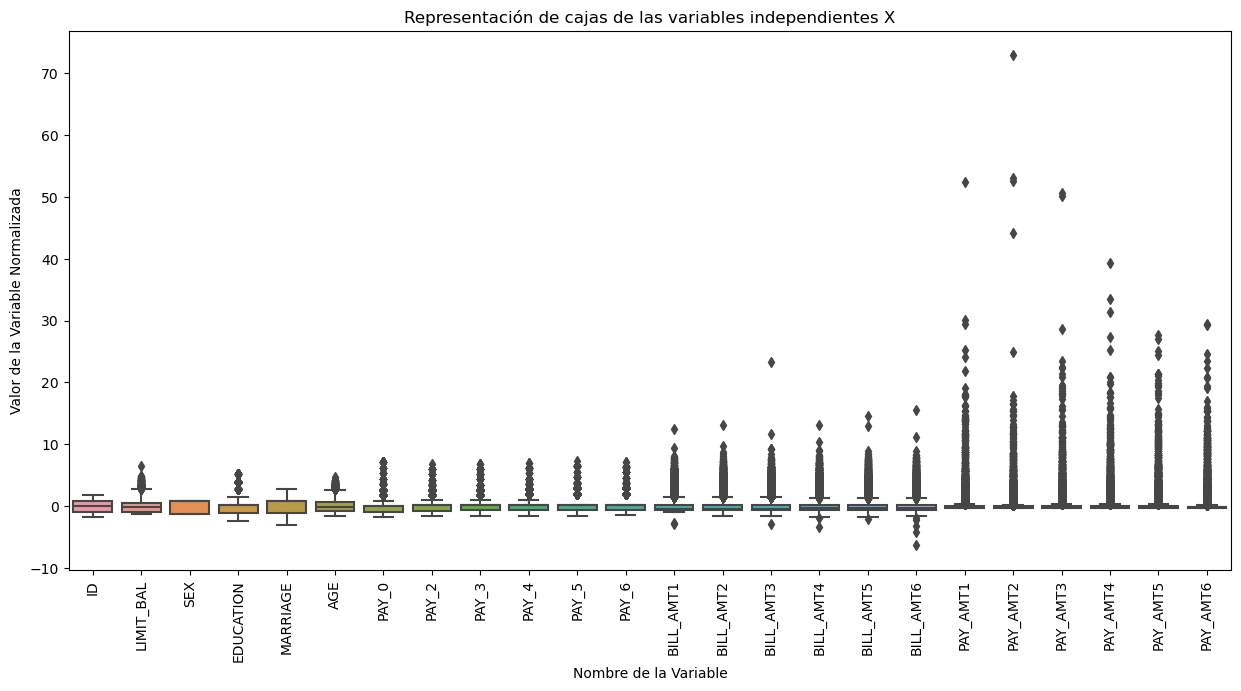

In [12]:
plt.figure(figsize=(15,7))
sns.boxplot(X_normalizado)
plt.xticks(rotation=90)
plt.title('Representación de cajas de las variables independientes X')
plt.xlabel('Nombre de la Variable')
plt.ylabel('Valor de la Variable Normalizada')

## Histogramas:

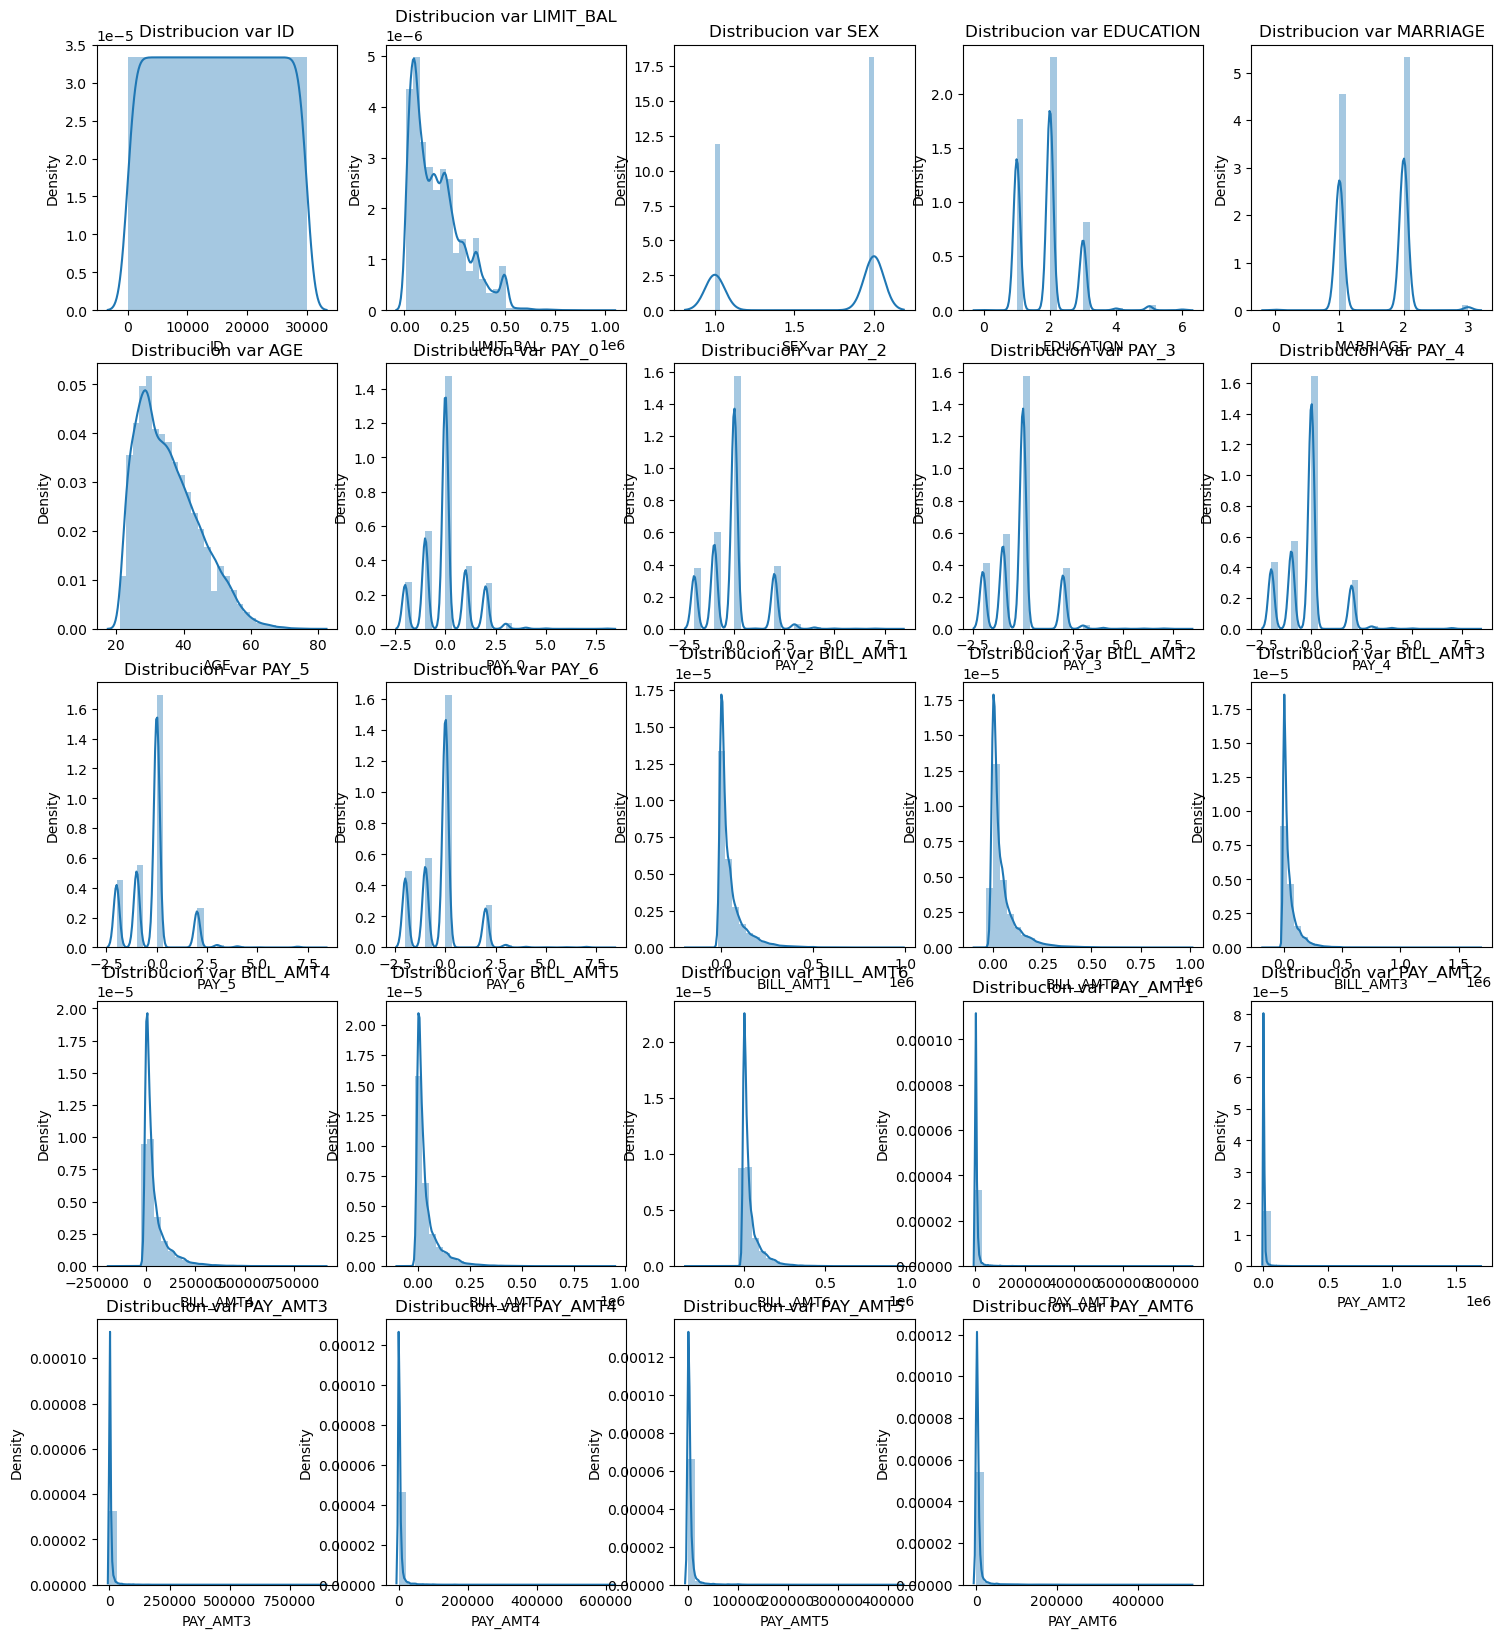

In [10]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(5, 5, n)
    sns.distplot(X[column], bins=30)
    plt.title(f'Distribucion var {column}')

## Relación variable vs target:

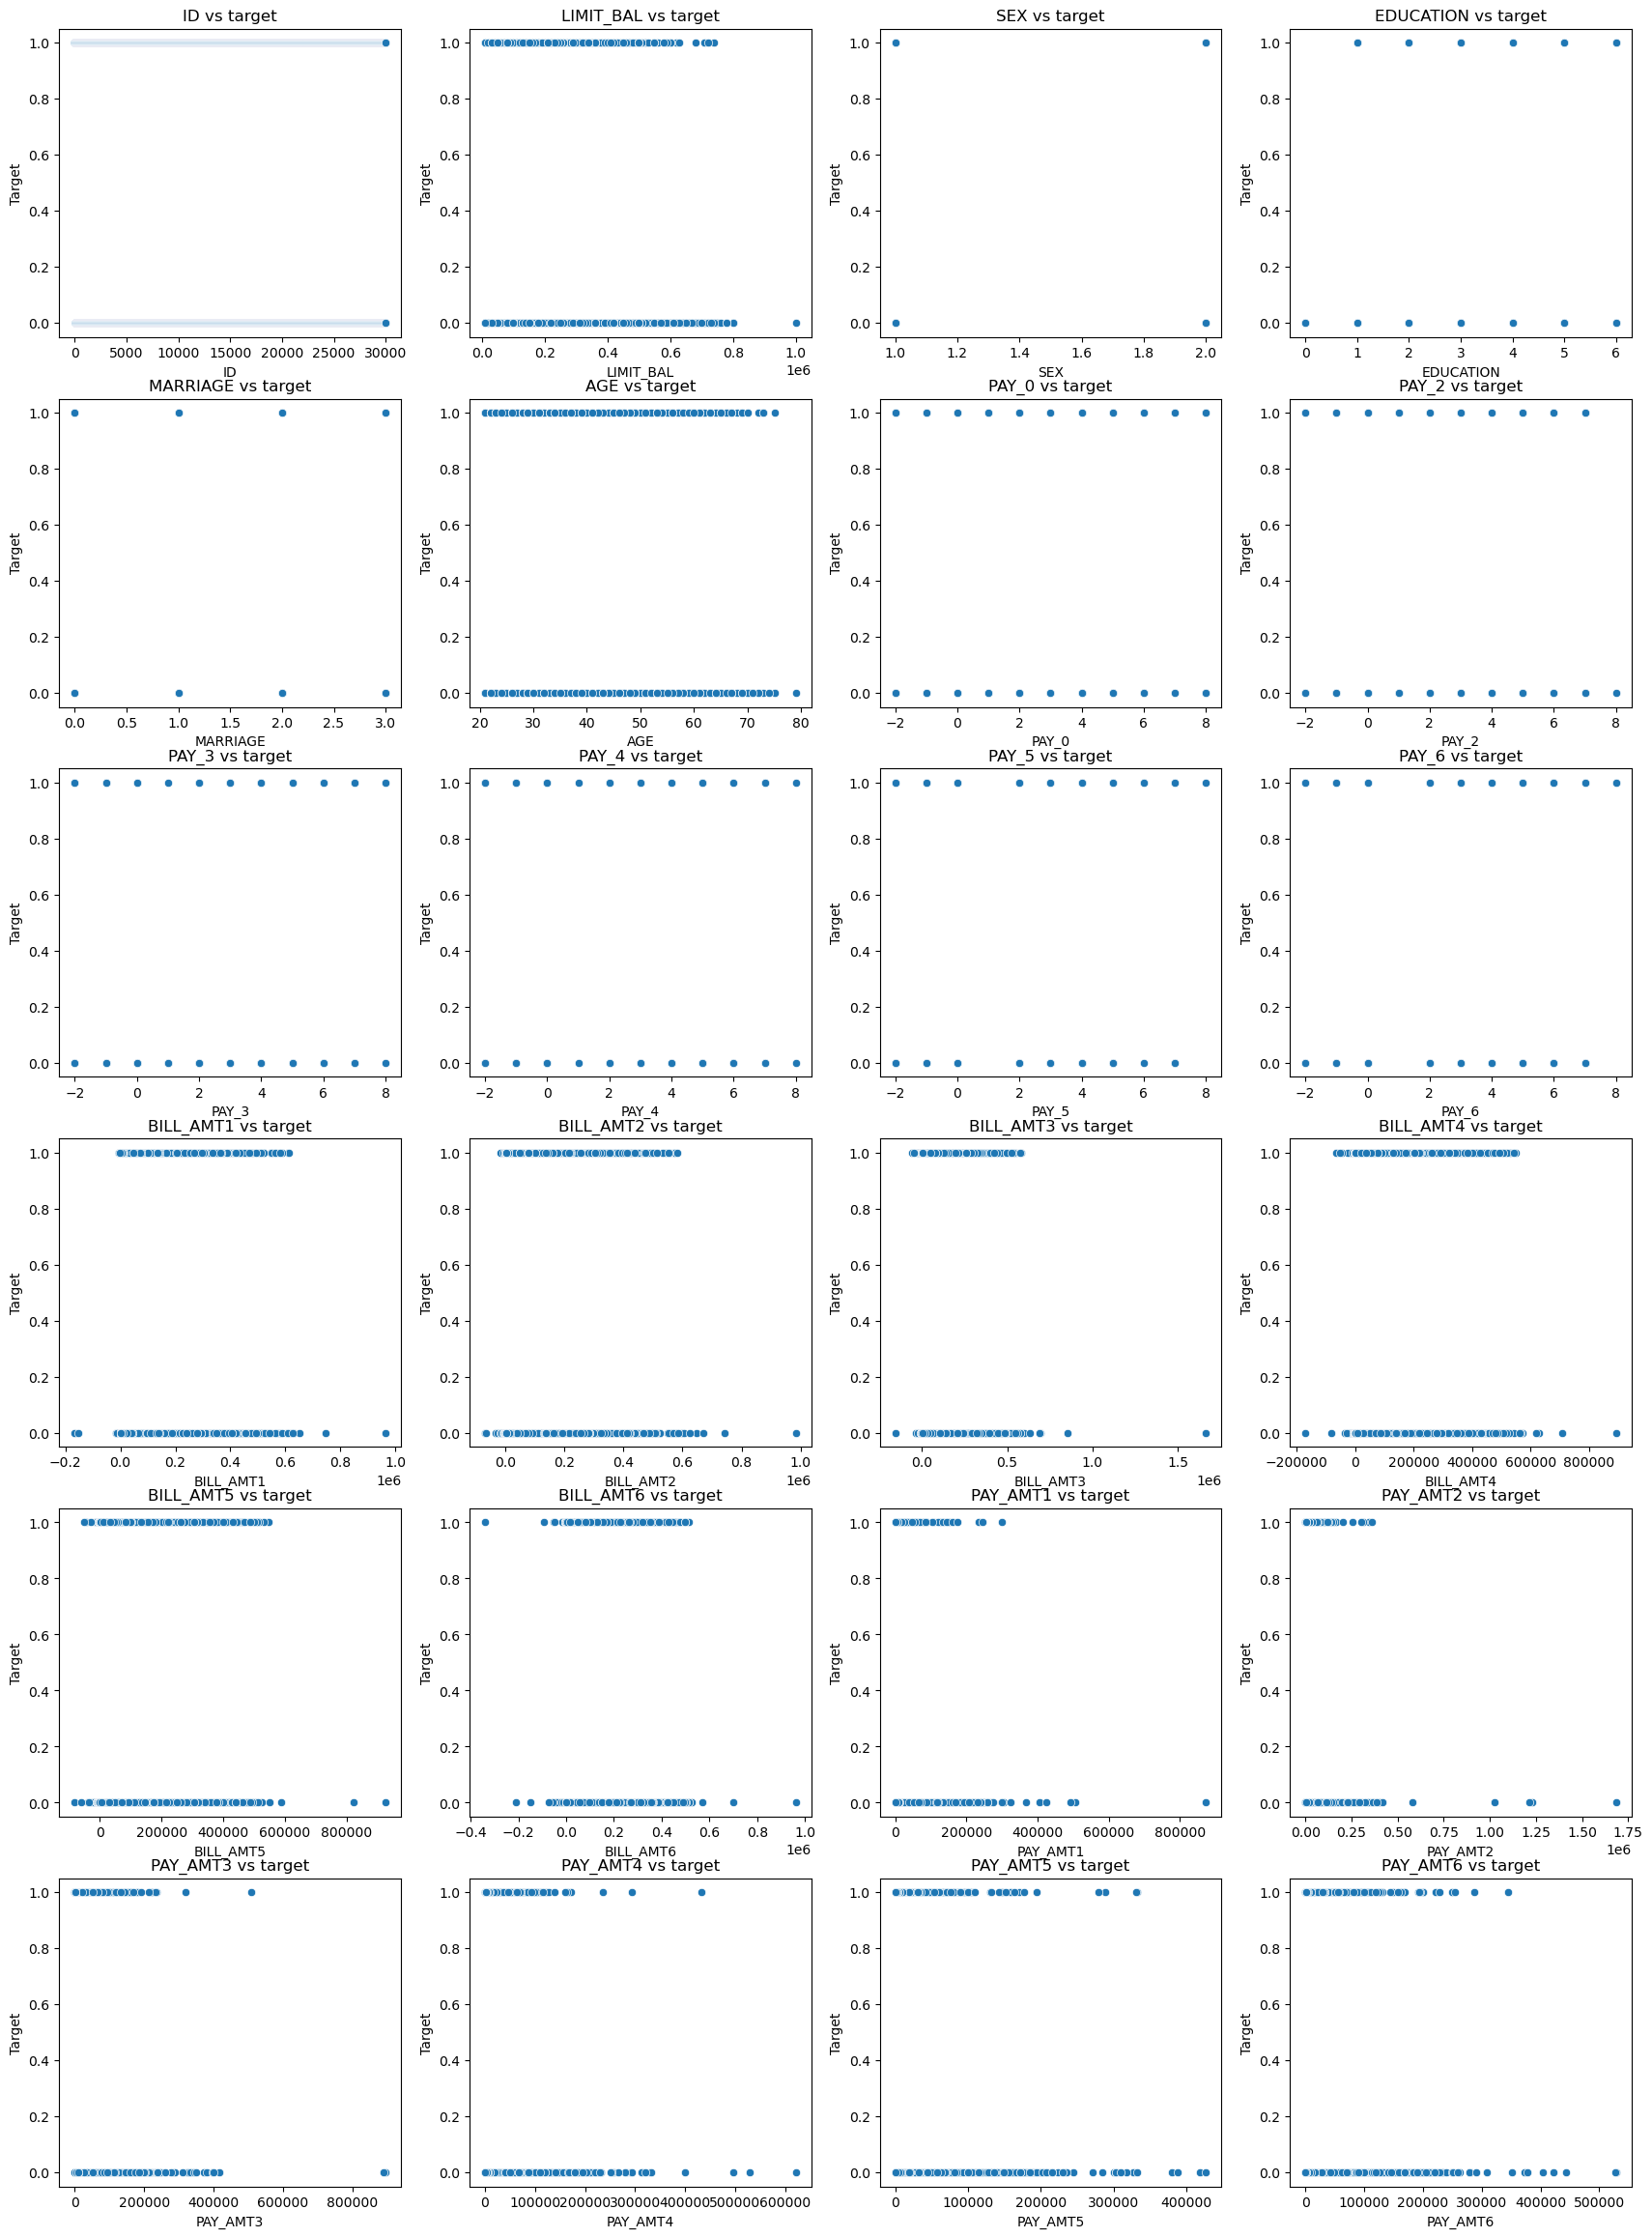

In [11]:
relaciones_vs_target(X, Y)

## Matriz de correlaciones:

Text(0.5, 1.0, 'Matriz de correlaciones de Pearson')

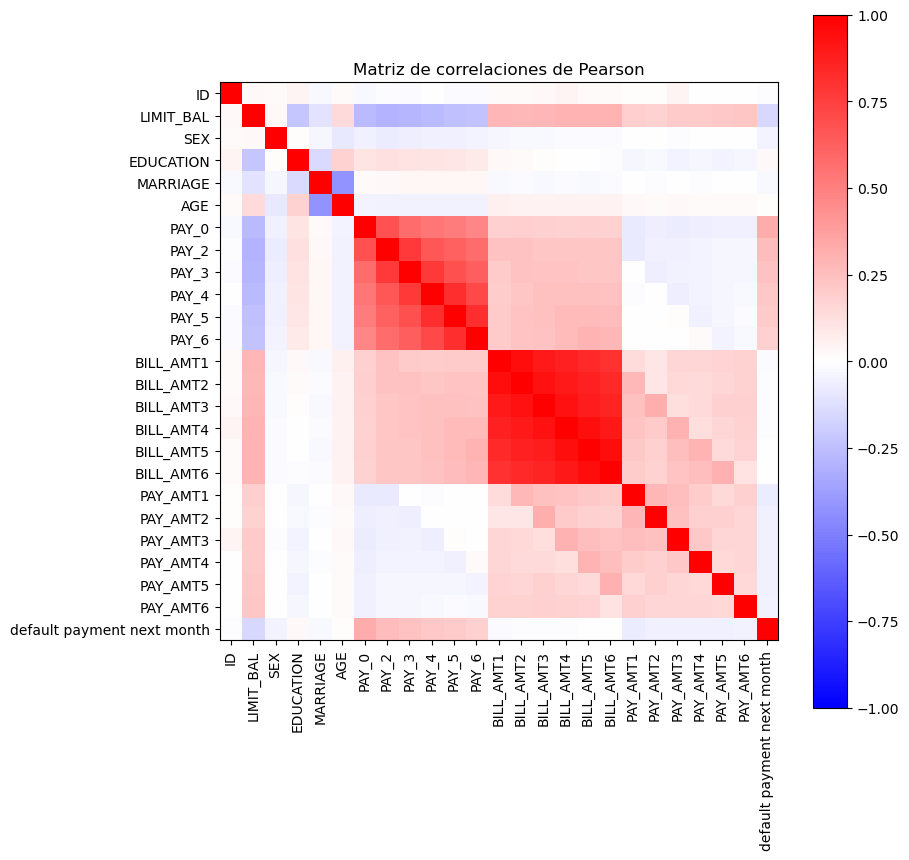

In [13]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure(figsize=(9, 9))
plt.xticks(range(n_ticks), XY.columns, rotation=90)
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', vmin=-1, vmax=1, cmap='bwr'))
plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlación con la target:

In [14]:
correlaciones_con_target = matriz_correlaciones['default payment next month'].sort_values(ascending=False)
correlaciones_con_target

default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
EDUCATION                     0.028006
AGE                           0.013890
BILL_AMT6                    -0.005372
BILL_AMT5                    -0.006760
BILL_AMT4                    -0.010156
ID                           -0.013952
BILL_AMT3                    -0.014076
BILL_AMT2                    -0.014193
BILL_AMT1                    -0.019644
MARRIAGE                     -0.024339
SEX                          -0.039961
PAY_AMT6                     -0.053183
PAY_AMT5                     -0.055124
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT2                     -0.058579
PAY_AMT1                     -0.072929
LIMIT_BAL                    -0.153520
Name: default payment nex

## Estandarización previa de los datos:

In [15]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test:

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)
#El 20% de mis datos se utilizarán como conjunto de prueba, mientras que el 80% se utilizarán como conjunto de entrenamiento (test_size=0.2)

## Aplicación de un modelo de redes neuronales

En este problema vamos a hacer uso de la librería sklearn. Esta librería cuenta con un clasificador llamado MLPClassifier, el cual es lo que se denomina un Multi-layer Perceptron Classifier.

Esta es la configuración más común y estándard de las redes neuronales. Cuentan con una capa de entrada, una de salida y múltiples capas ocultas. Se trata de una arquitectura de red neuronal fully-connected, es decir, las neuronas de cada capa se conectan a todas las neuronales de las capas anteriores y de las siguientes.

In [19]:
modelo = MLPClassifier()
parametros = {'solver': ['lbfgs'], #utilizamos el algoritmo'lbfgs', que es un algoritmo eficiente para problemas pequeños y medianos.
              'max_iter': [100,200,300,500], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 10), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(30, 35), # Número de neuronas en cada capa, se está explorando un rango de valores de 30 a 34 neuronas.
              'random_state':[0]}

In [20]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 3, 
                         scoring='roc_auc', n_jobs=-1, verbose=10)
modelo_gs.fit(X_train, Y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09]),
                         'hidden_layer_sizes': array([30, 31, 32, 33, 34]),
                         'max_iter': [100, 200, 300, 500], 'random_state': [0],
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=10)

Imprimimos los mejores hiperparámetros encontrados durante la búsqueda de hiperparámetros, así como el valor correspondiente de la métrica de evaluación ROC AUC

In [21]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'alpha': 0.1, 'hidden_layer_sizes': 30, 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'} 
ROC AUC: 0.77


## Mejores parámetros:

Obtenemos los mejores parámetros encontrados y ajustamos un modelo con esos parámetros:

In [22]:
mejor_modelo = MLPClassifier(**modelo_gs.best_params_, verbose=10)

In [23]:
mejor_modelo.fit(X_train, Y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=30, max_iter=100, random_state=0,
              solver='lbfgs', verbose=10)

## Análisis de las predicciones:

In [24]:
y_test_pred_prob = mejor_modelo.predict_proba(X_test) #Cada fila en este arreglo corresponde a una instancia en X_test (cliente), 
# y cada columna representa la probabilidad de pertenencia a una de las clases ("pago" o "impago"). Cada fila entera representa un cliente y 
#sus caracteristicas especificas

y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]] #Filtra para tener solamente aquellas filas donde Y = 1. Mi duda es que deberia estar 
#todos los valores del lado izquierdo por debajo de 0 que es el lado de impago, suponiendo que el umbral es de 5, entonces, cual es el umbral??
# tiene mas probabilidades de pagar que de no pagar. 

y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]] #La misma duda en este

In [25]:
preds = y_test_pred_prob[:,1]

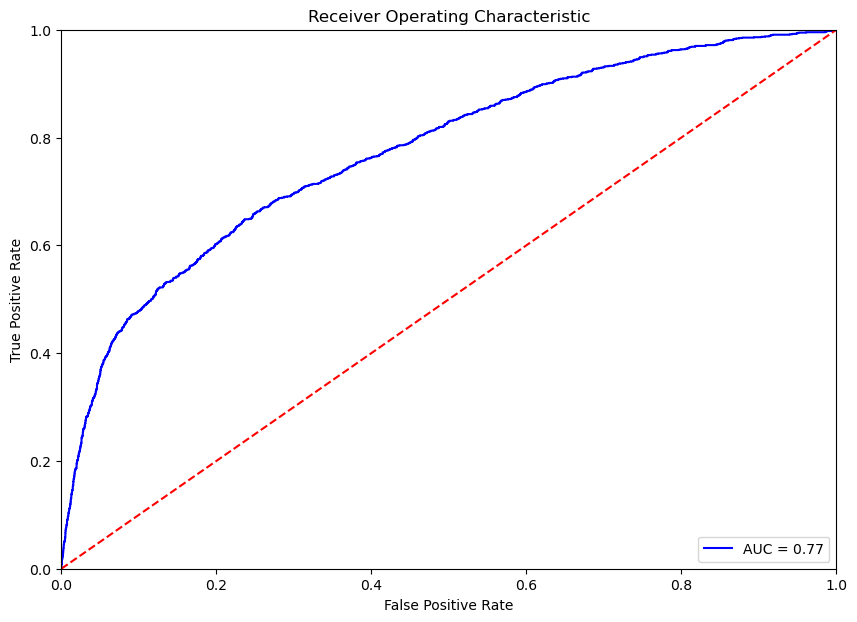

In [26]:
preds = y_test_pred_prob[:,1]
#Extrae del array la parte derecha del [  ,  ] (donde en teoria sería la probabilidad de pago)

fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Umbralizo las predicciones:

In [27]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
#Me va a indicar con el valor 1 si la probabilidad de pago está por encima del 0.5, si está por debajo del umbral (0.5) me dará 0.

In [28]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[4448  255]
 [ 800  497]]

Accuracy	0.82
Sensitividad	0.38
Precisión	0.66


* Verdaderos Positivos (TP): Hay 4448 casos en los que el modelo predijo correctamente que los clientes incumplirían con los pagos y efectivamente lo hicieron
* Falsos Positivos (FP): Se observan 255 casos en los que el modelo predijo incorrectamente que los clientes incumplirían con los pagos cuando, de hecho, no lo hicieron.
* Verdaderos Negativos (TN): Se encuentran 497 casos en los que el modelo predijo correctamente que los clientes no incumplirían con los pagos y efectivamente no lo hicieron.
* Falsos Negativos (FN): Hay 800 casos en los que el modelo predijo incorrectamente que los clientes no incumplirían con los pagos cuando, de hecho, sí lo hicieron.
* Accuracy: Es la proporción de predicciones correctas (tanto positivas como negativas) sobre el total de predicciones realizadas por el modelo. En nuestro caso, la exactitud es del 82%, lo que significa que el 82% de las predicciones del modelo fueron correctas.